# Learning Across $\frac{\chi}{\kappa}$ Regimes

Here we investigate optimal readouts in both low $\frac{\chi}{\kappa}$ and around $\frac{\chi}{\kappa} \approx 1$ to determine whether optimal readouts vary across regimes.

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [52]:
# Defining Cairo Params and RL Params

kappa = 25.0
chi = 0.65 * 2 * jnp.pi
kerr = 0.002
time_coeff = 10.0
snr_coeff = 10.
smoothness_coeff = 10.0
ideal_sep = 2.7
n0 = ideal_sep ** 2 * (1 + (chi / kappa) ** 2) / (4 * chi**2 / kappa**2)
print(f"N0: {n0}")
tau_0 = 100.0
res_amp_scaling = 1/0.43
nR = 0.1
snr_scale_factor = 1.
gamma_I = 1/110
photon_gamma = 0.
num_t1 = 12.0
init_fid = 0.999
photon_weight = 1.0

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": False,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

N0: 70.11312765834344


In [53]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight
)

In [54]:
rect_action = env.a0 * jnp.heaviside(tau_0 - env.ts_action, 0.)
# rect_action -= env.a0 * env.mu * (jnp.heaviside(0.35 - env.ts_action, 0.) - jnp.heaviside(0.3 - env.ts_action, 0.))
batch_action = jnp.tile(rect_action, (batchsize, 1))

batch_results = env.batched_results(batch_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    max_pf_times,
    b_smoothness,
    b_pf,
    b_higher_photons,
) = env.batched_extract_values(batch_results, batch_action)

pf_res = b_pf[0]
photon_res = b_higher_photons[0]

0.9960522808005797
129.06562215562633


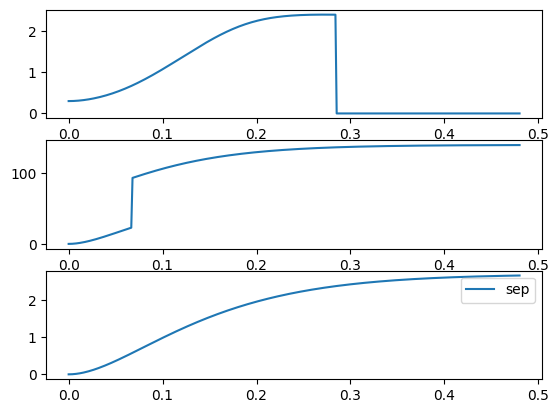

In [55]:
print(1 - 10**-np.max(pf_res))
print(np.min(photon_res[144:288]))

fig, ax = plt.subplots(3)

single_res = batch_results[0]
res_g = single_res[:,0] + 1.0j * single_res[:,1]
res_e = single_res[:,2] + 1.0j * single_res[:,3]
sep = jnp.abs(res_g - res_e)

ax[0].plot(env.ts_sim, pf_res)
ax[1].plot(env.ts_sim, photon_res)
ax[2].plot(env.ts_sim, sep, label='sep')
plt.legend()
plt.show()

## Training for Optimal Readouts in various $\frac{\chi}{\kappa} regimes$

In [56]:
num_exp = 5
batch_rng = jax.random.split(_rng, num_exp)
rng, _rng = jax.random.split(rng)

ones_arr = np.ones(num_exp)

ideal_sep = 2.7
kappa_vals = np.array([1.0, 2.5, 5.0, 15.0, 25.0])
chi_vals = chi * ones_arr
kerr_vals = kerr * ones_arr
time_coeff_vals = time_coeff * ones_arr
snr_coeff_vals = snr_coeff * ones_arr
smoothness_coeff_vals = smoothness_coeff * ones_arr
n0_vals = ideal_sep ** 2 * (1 + (chi / kappa_vals) ** 2) / (4 * chi**2 / kappa_vals**2)
tau_0_vals = tau_0 * ones_arr
res_amp_scaling_vals = res_amp_scaling * ones_arr
nR_vals = nR * ones_arr
snr_scale_factor_vals = snr_scale_factor * ones_arr
gamma_I_vals = gamma_I * ones_arr
photon_gamma_vals = photon_gamma * ones_arr
num_t1_vals = num_t1 * ones_arr
init_fid_vals = init_fid * ones_arr
photon_weight_vals = photon_weight * ones_arr

In [58]:
vmap_index_list = np.zeros(17, dtype=np.int8).tolist() + [None] * 2

multi_kappa_train = jit(
    vmap(PPO_make_train(config), in_axes=vmap_index_list), 
    static_argnums=(-2, -1)
)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
multi_kappa_result = multi_kappa_train(
    batch_rng, 
    kappa_vals,
    chi_vals,
    kerr_vals,
    time_coeff_vals,
    snr_coeff_vals,
    smoothness_coeff_vals,
    n0_vals,
    tau_0_vals,
    res_amp_scaling_vals,
    nR_vals,
    snr_scale_factor_vals,
    gamma_I_vals,
    photon_gamma_vals,
    num_t1_vals,
    init_fid_vals,
    photon_weight_vals,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
time taken: 1221.9346899986267


In [59]:
# Extracting Results

metrics = multi_kappa_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]

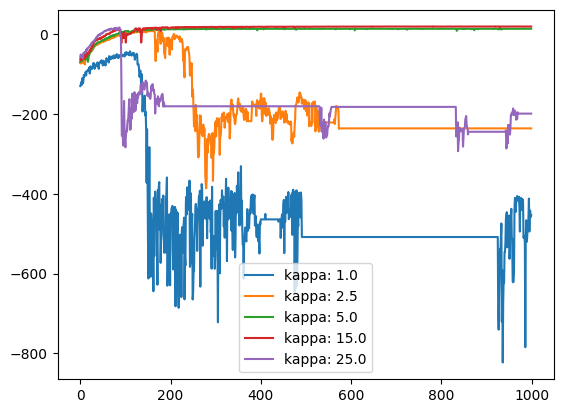

In [60]:
for i in range(5):
    plt.plot(mean_rewards[i, :, 0], label=f'kappa: {kappa_vals[i]}')
plt.legend()
plt.show()

(5, 121)


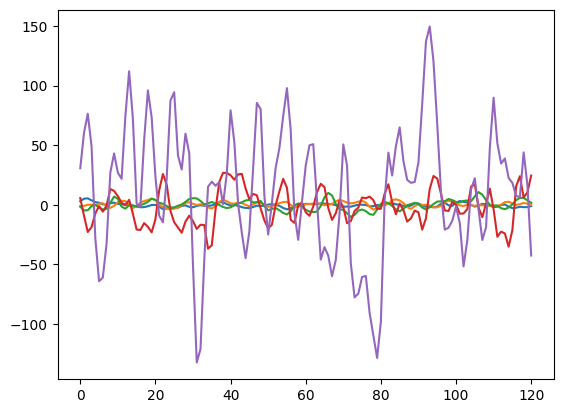

In [71]:
print(max_actions[:,0,0,:].shape)
plt.plot(max_actions[:,0,0,:].T)